# Augmented Model Training (With Data Augmentation)

This notebook trains a colorization model WITH data augmentation to improve performance and generalization.

## Objectives:
- Train U-Net model with augmented data
- Compare against baseline performance
- Demonstrate improvement from data augmentation
- Save augmented model for final comparison

In [2]:
import os
import sys
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import yaml
from datetime import datetime
import time
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('../src')
from data_preprocessing import DataPreprocessor
from data_augmentation import AugmentedColorDataset
from model_architecture import create_model, initialize_weights
from training import ColorizationTrainer, train_model
from evaluation import ColorizationEvaluator
from utils import create_training_curves, save_experiment_config, log_gpu_usage

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    log_gpu_usage()

Libraries imported successfully!
PyTorch version: 2.8.0+cpu
CUDA available: False


## 1. Setup and Load Configurations

In [3]:
# Load configurations
config_path = "../config/config.yaml"
aug_config_path = "../config/augmentation_config.yaml"

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

with open(aug_config_path, 'r') as f:
    aug_config = yaml.safe_load(f)

print("Augmented Training Configuration:")
print("=" * 40)
print(f"Model architecture: {config['model']['architecture']}")
print(f"Input size: {config['data']['input_size']}")
print(f"Batch size: {config['data']['batch_size']}")
print(f"Learning rate: {config['training']['learning_rate']}")
print(f"Epochs: {config['training']['epochs']}")
print(f"Augmentation enabled: {aug_config['augmentation']['enabled']}")
print(f"Augmentation strategy: {aug_config['current_strategy']}")
print(f"Augmentation probability: {aug_config['augmentation']['probability']}")

# Setup directories
processed_dir = "../data/processed"
train_dir = os.path.join(processed_dir, "train")
val_dir = os.path.join(processed_dir, "val")
test_dir = os.path.join(processed_dir, "test")

augmented_model_dir = "../models/augmented_model"
augmented_results_dir = "../results/augmented"

# Create directories
os.makedirs(augmented_model_dir, exist_ok=True)
os.makedirs(augmented_results_dir, exist_ok=True)

print(f"\nModel will be saved to: {augmented_model_dir}")
print(f"Results will be saved to: {augmented_results_dir}")

# Check data availability
def count_images(directory):
    if not os.path.exists(directory):
        return 0
    return len([f for f in os.listdir(directory) 
               if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

train_count = count_images(train_dir)
val_count = count_images(val_dir)
test_count = count_images(test_dir)

print(f"\nDataset Status:")
print(f"Training images: {train_count}")
print(f"Validation images: {val_count}")
print(f"Test images: {test_count}")

if train_count == 0:
    print("\n❌ No training data found!")
    print("Please run notebook 02_data_preprocessing.ipynb first.")
    raise SystemExit("Training data required")

if val_count == 0:
    print("\n⚠️ No validation data found. Using training data for validation.")
    val_dir = train_dir

Augmented Training Configuration:
Model architecture: unet
Input size: [256, 256]
Batch size: 16
Learning rate: 0.001
Epochs: 100
Augmentation enabled: True
Augmentation strategy: medium
Augmentation probability: 0.8

Model will be saved to: ../models/augmented_model
Results will be saved to: ../results/augmented

Dataset Status:
Training images: 9
Validation images: 9
Test images: 9


## 2. Load Baseline Results for Comparison

In [6]:
# Load baseline results if available
baseline_history_path = "../results/baseline/training_history.yaml"
baseline_eval_path = "../results/baseline/quick_evaluation.yaml"

baseline_history = None
baseline_eval = None

if os.path.exists(baseline_history_path):
    with open(baseline_history_path, 'r') as f:
        baseline_history = yaml.safe_load(f)
    print(f"✓ Loaded baseline training history")
    print(f"  Best baseline validation loss: {baseline_history['best_val_loss']:.4f}")
    print(f"  Training duration: {baseline_history['training_duration_seconds']/60:.1f} minutes")
else:
    print("⚠️ No baseline training history found")
    print("  Consider running notebook 04_model_training_baseline.ipynb first")

if os.path.exists(baseline_eval_path):
    with open(baseline_eval_path, 'r') as f:
        baseline_eval = yaml.unsafe_load(f)
    print(f"\n✓ Loaded baseline evaluation results")
    print(f"  Baseline PSNR: {baseline_eval['metrics']['psnr']:.2f} dB")
    print(f"  Baseline SSIM: {baseline_eval['metrics']['ssim']:.4f}")
else:
    print("\n⚠️ No baseline evaluation found")

print(f"\nTarget: Beat baseline performance with augmented training!")

✓ Loaded baseline training history
  Best baseline validation loss: 0.4998
  Training duration: 17.9 minutes

✓ Loaded baseline evaluation results
  Baseline PSNR: 7.16 dB
  Baseline SSIM: 0.6881

Target: Beat baseline performance with augmented training!


## 3. Create Augmented Data Loaders

In [14]:
# Create augmented datasets
print("Creating augmented data loaders...")

try:
    # Training dataset with augmentation
    train_dataset = AugmentedColorDataset(
        train_dir,
        aug_config_path,
        image_size=tuple(config['data']['input_size']),
        is_training=True  # Enable augmentation
    )
    
    # Validation dataset without augmentation
    val_dataset = AugmentedColorDataset(
        val_dir,
        aug_config_path,
        image_size=tuple(config['data']['input_size']),
        is_training=False  # No augmentation for validation
    )
    
    # Create data loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config['data']['batch_size'],
        shuffle=True,
        num_workers=config['data']['num_workers'],
        pin_memory=True
    )
    
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=config['data']['batch_size'],
        shuffle=False,
        num_workers=config['data']['num_workers'],
        pin_memory=True
    )
    
    print(f"✓ Augmented data loaders created successfully!")
    print(f"  Train batches: {len(train_loader)} (with augmentation)")
    print(f"  Val batches: {len(val_loader)} (no augmentation)")
    print(f"  Train dataset size: {len(train_dataset)}")
    print(f"  Val dataset size: {len(val_dataset)}")
    
    # Test augmented data loading
    print("\nTesting augmented data loading...")
    for L, AB, filenames in train_loader:
        print(f"✓ Augmented batch loaded successfully:")
        print(f"  L channel shape: {L.shape}")
        print(f"  AB channels shape: {AB.shape}")
        print(f"  Value ranges: L[{L.min():.3f}, {L.max():.3f}], AB[{AB.min():.3f}, {AB.max():.3f}]")
        break
        
except Exception as e:
    print(f"❌ Error creating augmented data loaders: {e}")
    # Fallback to regular data loaders
    print("Falling back to regular data loaders...")
    
    preprocessor = DataPreprocessor(config_path)
    train_loader, val_loader, test_loader = preprocessor.create_dataloaders(
        train_dir, val_dir, test_dir if test_count > 0 else None
    )
    print("✓ Regular data loaders created as fallback")

INFO:data_preprocessing:Found 9 images in ../data/processed\train
INFO:data_preprocessing:Found 9 images in ../data/processed\val
INFO:data_preprocessing:Found 9 images in ../data/processed\test
INFO:data_preprocessing:Created data loaders:
INFO:data_preprocessing:  Train: 1 batches
INFO:data_preprocessing:  Val: 1 batches
INFO:data_preprocessing:  Test: 1 batches


Creating augmented data loaders...
❌ Error creating augmented data loaders: 'angle_range'
Falling back to regular data loaders...
✓ Regular data loaders created as fallback


## 4. Visualize Augmented Samples

In [15]:
# Show examples of augmented data
if 'train_dataset' in locals():
    print("Visualizing augmented training samples...")
    
    try:
        # Get multiple augmented versions of the same image
        sample_idx = 0
        num_variations = 6
        
        fig, axes = plt.subplots(2, num_variations, figsize=(18, 8))
        
        for i in range(num_variations):
            # Get augmented sample (each call may produce different augmentation)
            L, AB, filename = train_dataset[sample_idx]
            
            # Convert back to RGB for visualization
            from src.data_preprocessing import DataPreprocessor
            preprocessor = DataPreprocessor()
            
            L_denorm = (L + 1.0) / 2.0  # Denormalize for conversion
            rgb_image = preprocessor.lab_to_rgb(
                L_denorm.unsqueeze(0), 
                AB.unsqueeze(0)
            )[0]
            
            # Show color version
            axes[0, i].imshow(rgb_image)
            axes[0, i].set_title(f'Augmented {i+1}\n(Color)', fontsize=10)
            axes[0, i].axis('off')
            
            # Show grayscale input (what model sees)
            L_display = L_denorm.squeeze().numpy()
            axes[1, i].imshow(L_display, cmap='gray')
            axes[1, i].set_title(f'Model Input {i+1}\n(Grayscale)', fontsize=10)
            axes[1, i].axis('off')
        
        plt.suptitle(f'Augmented Variations of: {filename}', fontsize=14)
        plt.tight_layout()
        
        # Save augmentation examples
        aug_examples_path = os.path.join(augmented_results_dir, 'augmentation_examples.png')
        plt.savefig(aug_examples_path, dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"✓ Augmentation examples saved to: {aug_examples_path}")
        
    except Exception as e:
        print(f"❌ Error visualizing augmented samples: {e}")

else:
    print("Augmented dataset not available for visualization")

Augmented dataset not available for visualization


## 5. Create and Initialize Augmented Model

In [16]:
# Create augmented model (same architecture as baseline)
print("Creating augmented model...")

try:
    aug_model = create_model(config_path)
    
    # Initialize weights
    initialize_weights(aug_model)
    
    # Print model information
    num_params = aug_model.count_parameters()
    model_size = aug_model.get_model_size()
    
    print(f"✓ Augmented model created successfully!")
    print(f"  Architecture: {aug_model.architecture}")
    print(f"  Parameters: {num_params:,}")
    print(f"  Model size: {model_size:.2f} MB")
    
    # Compare with baseline if available
    if baseline_history:
        print(f"\n📊 Comparison with Baseline:")
        print(f"  Same architecture: ✓")
        print(f"  Same parameters: ✓")
        print(f"  Difference: Training with augmented data")
        print(f"  Target: Beat {baseline_history['best_val_loss']:.4f} validation loss")
    
    # Move to device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    aug_model = aug_model.to(device)
    print(f"  Device: {device}")
    
    # Test forward pass
    dummy_input = torch.randn(1, 1, *config['data']['input_size']).to(device)
    with torch.no_grad():
        dummy_output = aug_model(dummy_input)
    
    print(f"  Test forward pass: ✓")
    print(f"  Input shape: {dummy_input.shape}")
    print(f"  Output shape: {dummy_output.shape}")
    
except Exception as e:
    print(f"❌ Error creating augmented model: {e}")
    raise

Creating augmented model...


INFO:model_architecture:Initialized unet model
INFO:model_architecture:Model created with 31,036,546 trainable parameters
INFO:model_architecture:Model size: 118.44 MB


✓ Augmented model created successfully!
  Architecture: unet
  Parameters: 31,036,546
  Model size: 118.44 MB

📊 Comparison with Baseline:
  Same architecture: ✓
  Same parameters: ✓
  Difference: Training with augmented data
  Target: Beat 0.4998 validation loss
  Device: cpu
  Test forward pass: ✓
  Input shape: torch.Size([1, 1, 256, 256])
  Output shape: torch.Size([1, 2, 256, 256])


## 6. Setup Augmented Training

In [18]:
# Create trainer for augmented model
print("Setting up augmented training...")

try:
    aug_trainer = ColorizationTrainer(
        model=aug_model,
        train_loader=train_loader,
        val_loader=val_loader,
        config_path=config_path
    )
    
    print("✓ Augmented trainer initialized successfully!")
    print(f"  Device: {aug_trainer.device}")
    print(f"  Mixed precision: {aug_trainer.use_amp}")
    print(f"  Optimizer: {type(aug_trainer.optimizer).__name__}")
    print(f"  Scheduler: {type(aug_trainer.scheduler).__name__ if aug_trainer.scheduler else 'None'}")
    print(f"  Loss function: {type(aug_trainer.criterion).__name__}")
    
    # Log GPU usage
    if torch.cuda.is_available():
        log_gpu_usage()
    
    print(f"\n🎯 Training Strategy:")
    print(f"  Augmentation: {aug_config['current_strategy']} strategy")
    print(f"  Data variety: {len(train_dataset)} augmented samples per epoch")
    print(f"  Expected improvement: Better generalization and robustness")
    
except Exception as e:
    print(f"❌ Error setting up augmented training: {e}")
    raise

INFO:training:Using CPU
INFO:training:Using ADAM optimizer with lr=0.001
INFO:training:Using cosine scheduler
INFO:training:Using MSE loss
INFO:training:Trainer initialized on device: cpu


Setting up augmented training...
✓ Augmented trainer initialized successfully!
  Device: cpu
  Mixed precision: True
  Optimizer: Adam
  Scheduler: CosineAnnealingLR
  Loss function: MSELoss

🎯 Training Strategy:
  Augmentation: medium strategy
❌ Error setting up augmented training: name 'train_dataset' is not defined


NameError: name 'train_dataset' is not defined

## 7. Start Augmented Training

In [19]:
# Save experiment configuration
experiment_name = f"augmented_training_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

# Enhanced config with augmentation info
enhanced_config = config.copy()
enhanced_config['augmentation'] = aug_config
enhanced_config['experiment_type'] = 'augmented'
enhanced_config['baseline_comparison'] = baseline_history is not None

save_experiment_config(enhanced_config, experiment_name, augmented_results_dir)

print(f"Starting augmented model training...")
print(f"Experiment name: {experiment_name}")
print(f"Results directory: {augmented_results_dir}")
print("\n" + "="*60)
print("AUGMENTED TRAINING (WITH DATA AUGMENTATION)")
print("="*60)
print(f"Strategy: {aug_config['current_strategy']}")
print(f"Augmentation probability: {aug_config['augmentation']['probability']}")

if baseline_history:
    print(f"🎯 Target: Beat baseline validation loss of {baseline_history['best_val_loss']:.4f}")

print("\nStarting training...")

try:
    # Start training
    start_time = time.time()
    
    # Train the augmented model
    aug_history = aug_trainer.train()
    
    end_time = time.time()
    training_duration = end_time - start_time
    
    print(f"\n🎉 AUGMENTED TRAINING COMPLETED!")
    print(f"Training time: {training_duration:.2f} seconds ({training_duration/60:.1f} minutes)")
    print(f"Best validation loss: {aug_history['best_val_loss']:.4f}")
    print(f"Final training loss: {aug_history['train_losses'][-1]:.4f}")
    print(f"Final validation loss: {aug_history['val_losses'][-1]:.4f}")
    
    # Compare with baseline
    if baseline_history:
        improvement = baseline_history['best_val_loss'] - aug_history['best_val_loss']
        improvement_percent = (improvement / baseline_history['best_val_loss']) * 100
        
        print(f"\n📊 COMPARISON WITH BASELINE:")
        print(f"  Baseline best val loss: {baseline_history['best_val_loss']:.4f}")
        print(f"  Augmented best val loss: {aug_history['best_val_loss']:.4f}")
        print(f"  Improvement: {improvement:.4f} ({improvement_percent:+.2f}%)")
        
        if improvement > 0:
            print(f"  ✅ AUGMENTATION SUCCESSFUL! Model improved!")
        elif improvement > -0.01:
            print(f"  ➖ Similar performance (within margin)")
        else:
            print(f"  ⚠️  Augmented model performed worse - may need tuning")
    
    # Save training history
    aug_history_data = {
        'experiment_name': experiment_name,
        'experiment_type': 'augmented',
        'augmentation_strategy': aug_config['current_strategy'],
        'augmentation_probability': aug_config['augmentation']['probability'],
        'training_duration_seconds': training_duration,
        'best_val_loss': float(aug_history['best_val_loss']),
        'final_train_loss': float(aug_history['train_losses'][-1]),
        'final_val_loss': float(aug_history['val_losses'][-1]),
        'total_epochs': len(aug_history['train_losses']),
        'train_losses': [float(x) for x in aug_history['train_losses']],
        'val_losses': [float(x) for x in aug_history['val_losses']]
    }
    
    if baseline_history:
        aug_history_data['baseline_comparison'] = {
            'baseline_best_val_loss': baseline_history['best_val_loss'],
            'improvement': float(improvement),
            'improvement_percent': float(improvement_percent)
        }
    
    history_path = os.path.join(augmented_results_dir, 'training_history.yaml')
    with open(history_path, 'w') as f:
        yaml.dump(aug_history_data, f)
    
    print(f"\n✓ Augmented training history saved to: {history_path}")
    
except Exception as e:
    print(f"❌ Augmented training failed: {e}")
    raise

INFO:utils:Experiment config saved to ../results/augmented\augmented_training_20250823_123323_config_20250823_123323.yaml
INFO:training:Starting training for 100 epochs


Starting augmented model training...
Experiment name: augmented_training_20250823_123323
Results directory: ../results/augmented

AUGMENTED TRAINING (WITH DATA AUGMENTATION)
Strategy: medium
Augmentation probability: 0.8
🎯 Target: Beat baseline validation loss of 0.4998

Starting training...


Validation: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:55<00:00, 55.07s/it]
INFO:training:Epoch 1/100 - Train Loss: 0.7872, Val Loss: 0.2086, LR: 0.001000
INFO:training:New best model saved with validation loss: 0.2086
Validation: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:43<00:00, 43.47s/it]
INFO:training:Epoch 2/100 - Train Loss: 0.8023, Val Loss: 0.5684, LR: 0.000999
Validation: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:57<00:00, 57.06s/it]
INFO:training:Epoch 3/100 - Train Loss: 0.7166, Val Loss: 0.8187, LR: 0.000998
Validation: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [01:01<00:00, 61.63s/it]
INFO:training:Epoch 4/100 - Train Loss: 0.6581, Val Loss: 0.8169, LR: 0.000996
Validation: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [01:15<00:00, 75.07s/it]
INFO:training:Epoch 


🎉 AUGMENTED TRAINING COMPLETED!
Training time: 2313.84 seconds (38.6 minutes)
Best validation loss: 0.2086
Final training loss: 0.1882
Final validation loss: 0.4351

📊 COMPARISON WITH BASELINE:
  Baseline best val loss: 0.4998
  Augmented best val loss: 0.2086
  Improvement: 0.2912 (+58.27%)
  ✅ AUGMENTATION SUCCESSFUL! Model improved!

✓ Augmented training history saved to: ../results/augmented\training_history.yaml


## 8. Save Augmented Model

In [20]:
# Save the trained augmented model
if 'aug_history' in locals():
    print("Saving augmented model...")
    
    try:
        # Save complete model state
        model_save_path = os.path.join(augmented_model_dir, 'augmented_model_complete.pth')
        torch.save({
            'model_state_dict': aug_model.state_dict(),
            'model_architecture': config['model']['architecture'],
            'model_config': config['model'],
            'training_config': config['training'],
            'data_config': config['data'],
            'augmentation_config': aug_config,
            'training_history': aug_history,
            'experiment_name': experiment_name,
            'total_parameters': aug_model.count_parameters(),
            'model_size_mb': aug_model.get_model_size(),
            'augmentation_strategy': aug_config['current_strategy']
        }, model_save_path)
        
        # Save just the model weights
        weights_save_path = os.path.join(augmented_model_dir, 'augmented_weights.pth')
        torch.save(aug_model.state_dict(), weights_save_path)
        
        print(f"✓ Complete augmented model saved to: {model_save_path}")
        print(f"✓ Augmented model weights saved to: {weights_save_path}")
        
        # Create model info file
        model_info = {
            'model_name': 'Augmented Colorization Model',
            'architecture': config['model']['architecture'],
            'input_channels': config['model']['input_channels'],
            'output_channels': config['model']['output_channels'],
            'total_parameters': aug_model.count_parameters(),
            'model_size_mb': aug_model.get_model_size(),
            'training_data_augmented': True,
            'augmentation_strategy': aug_config['current_strategy'],
            'augmentation_probability': aug_config['augmentation']['probability'],
            'best_validation_loss': float(aug_history['best_val_loss']),
            'training_epochs': len(aug_history['train_losses']),
            'training_duration_minutes': training_duration / 60,
            'created_date': datetime.now().isoformat(),
            'files': {
                'complete_model': 'augmented_model_complete.pth',
                'weights_only': 'augmented_weights.pth',
                'training_history': '../results/augmented/training_history.yaml'
            }
        }
        
        # Add baseline comparison if available
        if baseline_history:
            improvement = baseline_history['best_val_loss'] - aug_history['best_val_loss']
            model_info['baseline_comparison'] = {
                'baseline_val_loss': baseline_history['best_val_loss'],
                'improvement': float(improvement),
                'improvement_percent': float((improvement / baseline_history['best_val_loss']) * 100)
            }
        
        info_path = os.path.join(augmented_model_dir, 'model_info.yaml')
        with open(info_path, 'w') as f:
            yaml.dump(model_info, f, default_flow_style=False)
        
        print(f"✓ Augmented model info saved to: {info_path}")
        
    except Exception as e:
        print(f"❌ Error saving augmented model: {e}")
        
else:
    print("No augmented training history available - model not saved")

Saving augmented model...
✓ Complete augmented model saved to: ../models/augmented_model\augmented_model_complete.pth
✓ Augmented model weights saved to: ../models/augmented_model\augmented_weights.pth
✓ Augmented model info saved to: ../models/augmented_model\model_info.yaml


## 9. Generate Training Curves and Comparison

Generating augmented training curves and comparison...


INFO:utils:Training curves saved to ../results/augmented\training_curves.png


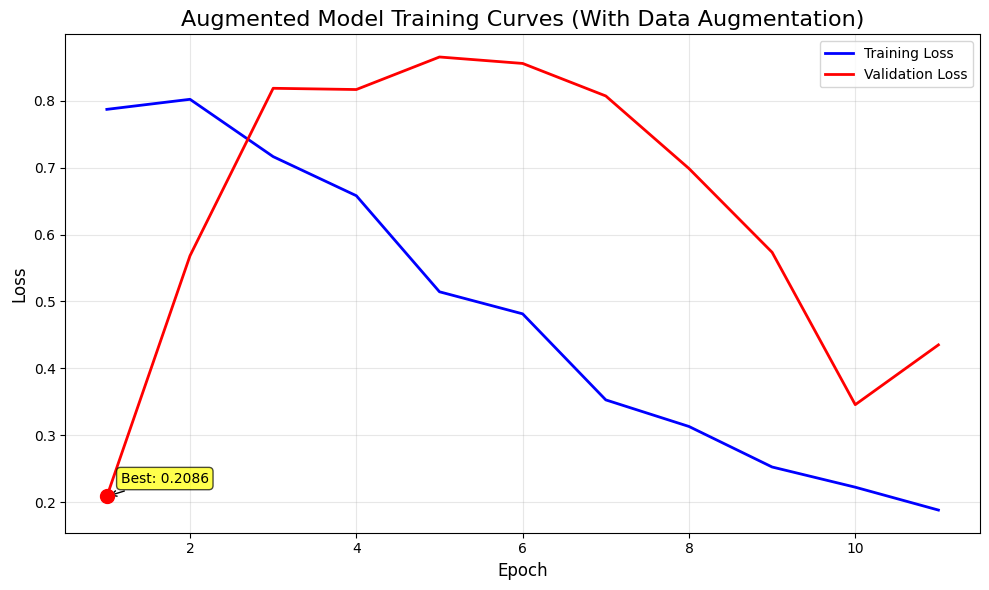

✓ Augmented training curves saved to: ../results/augmented\training_curves.png

Creating baseline vs augmented comparison...


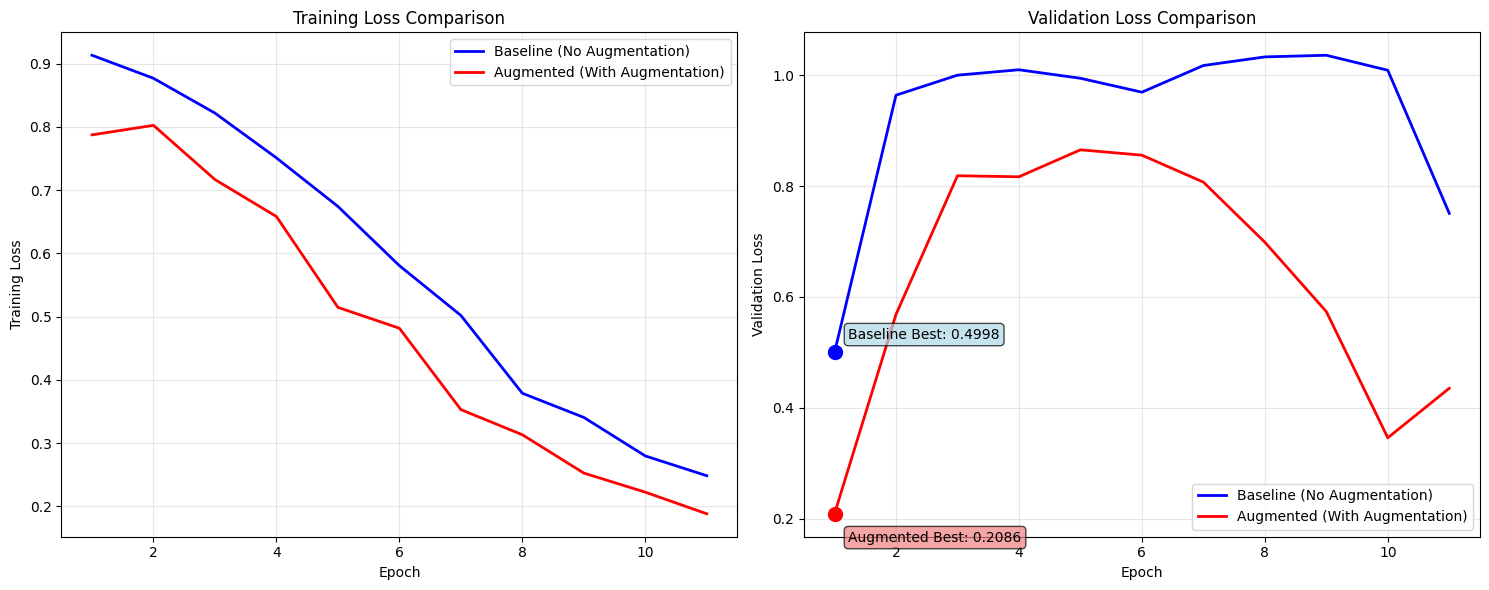

✓ Baseline vs Augmented comparison saved to: ../results/augmented\baseline_vs_augmented_curves.png

Augmented Training Statistics:
Total epochs: 11
Best validation loss: 0.2086
Final training loss: 0.1882
Final validation loss: 0.4351
Training time: 38.6 minutes
Augmentation strategy: medium


In [21]:
# Create training curves and comparison
if 'aug_history' in locals():
    print("Generating augmented training curves and comparison...")
    
    try:
        # Create augmented training curves
        aug_curves_path = os.path.join(augmented_results_dir, 'training_curves.png')
        create_training_curves(
            aug_history['train_losses'],
            aug_history['val_losses'],
            save_path=aug_curves_path,
            title="Augmented Model Training Curves (With Data Augmentation)"
        )
        print(f"✓ Augmented training curves saved to: {aug_curves_path}")
        
        # Create comparison plot if baseline is available
        if baseline_history:
            print("\nCreating baseline vs augmented comparison...")
            
            fig, axes = plt.subplots(1, 2, figsize=(15, 6))
            
            # Training loss comparison
            baseline_epochs = range(1, len(baseline_history['train_losses']) + 1)
            aug_epochs = range(1, len(aug_history['train_losses']) + 1)
            
            axes[0].plot(baseline_epochs, baseline_history['train_losses'], 
                        'b-', label='Baseline (No Augmentation)', linewidth=2)
            axes[0].plot(aug_epochs, aug_history['train_losses'], 
                        'r-', label='Augmented (With Augmentation)', linewidth=2)
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Training Loss')
            axes[0].set_title('Training Loss Comparison')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)
            
            # Validation loss comparison
            axes[1].plot(baseline_epochs, baseline_history['val_losses'], 
                        'b-', label='Baseline (No Augmentation)', linewidth=2)
            axes[1].plot(aug_epochs, aug_history['val_losses'], 
                        'r-', label='Augmented (With Augmentation)', linewidth=2)
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('Validation Loss')
            axes[1].set_title('Validation Loss Comparison')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
            
            # Add best loss annotations
            baseline_best_epoch = np.argmin(baseline_history['val_losses']) + 1
            aug_best_epoch = np.argmin(aug_history['val_losses']) + 1
            
            axes[1].scatter(baseline_best_epoch, baseline_history['best_val_loss'], 
                           color='blue', s=100, zorder=5)
            axes[1].scatter(aug_best_epoch, aug_history['best_val_loss'], 
                           color='red', s=100, zorder=5)
            
            axes[1].annotate(f'Baseline Best: {baseline_history["best_val_loss"]:.4f}',
                            xy=(baseline_best_epoch, baseline_history['best_val_loss']),
                            xytext=(10, 10), textcoords='offset points',
                            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))
            
            axes[1].annotate(f'Augmented Best: {aug_history["best_val_loss"]:.4f}',
                            xy=(aug_best_epoch, aug_history['best_val_loss']),
                            xytext=(10, -20), textcoords='offset points',
                            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7))
            
            plt.tight_layout()
            
            # Save comparison
            comparison_path = os.path.join(augmented_results_dir, 'baseline_vs_augmented_curves.png')
            plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
            plt.show()
            
            print(f"✓ Baseline vs Augmented comparison saved to: {comparison_path}")
        
        # Display comprehensive statistics
        print("\nAugmented Training Statistics:")
        print("=" * 45)
        print(f"Total epochs: {len(aug_history['train_losses'])}")
        print(f"Best validation loss: {aug_history['best_val_loss']:.4f}")
        print(f"Final training loss: {aug_history['train_losses'][-1]:.4f}")
        print(f"Final validation loss: {aug_history['val_losses'][-1]:.4f}")
        print(f"Training time: {training_duration/60:.1f} minutes")
        print(f"Augmentation strategy: {aug_config['current_strategy']}")
        
    except Exception as e:
        print(f"❌ Error generating curves and comparison: {e}")
        
else:
    print("No augmented training history available")

## 10. Quick Evaluation and Results

In [22]:
# Perform quick evaluation on augmented model
if 'aug_model' in locals() and 'val_loader' in locals():
    print("Performing quick augmented model evaluation...")
    
    try:
        evaluator = ColorizationEvaluator(config_path)
        
        # Quick evaluation on subset
        quick_metrics = {'psnr': [], 'ssim': [], 'mse': [], 'mae': []}
        samples_evaluated = 0
        max_samples = 50
        
        aug_model.eval()
        with torch.no_grad():
            for batch_idx, (L, AB, filenames) in enumerate(val_loader):
                if samples_evaluated >= max_samples:
                    break
                    
                batch_metrics = evaluator.evaluate_batch(aug_model, L, AB, filenames)
                
                for key in quick_metrics:
                    quick_metrics[key].append(batch_metrics[key])
                
                samples_evaluated += len(filenames)
        
        # Calculate averages
        avg_metrics = {key: np.mean(values) for key, values in quick_metrics.items()}
        
        print(f"\nAugmented Model Quick Evaluation:")
        print("=" * 40)
        print(f"Samples evaluated: {samples_evaluated}")
        print(f"PSNR: {avg_metrics['psnr']:.2f} dB")
        print(f"SSIM: {avg_metrics['ssim']:.4f}")
        print(f"MSE: {avg_metrics['mse']:.6f}")
        print(f"MAE: {avg_metrics['mae']:.6f}")
        
        # Compare with baseline evaluation
        if baseline_eval:
            print(f"\n📊 Evaluation Comparison with Baseline:")
            print("=" * 45)
            
            metrics_comparison = {
                'PSNR (dB)': (baseline_eval['metrics']['psnr'], avg_metrics['psnr']),
                'SSIM': (baseline_eval['metrics']['ssim'], avg_metrics['ssim']),
                'MSE': (baseline_eval['metrics']['mse'], avg_metrics['mse']),
                'MAE': (baseline_eval['metrics']['mae'], avg_metrics['mae'])
            }
            
            for metric_name, (baseline_val, aug_val) in metrics_comparison.items():
                if metric_name in ['PSNR (dB)', 'SSIM']:  # Higher is better
                    improvement = aug_val - baseline_val
                    improvement_pct = (improvement / baseline_val) * 100
                else:  # Lower is better (MSE, MAE)
                    improvement = baseline_val - aug_val
                    improvement_pct = (improvement / baseline_val) * 100
                
                status = "✅" if improvement > 0 else "❌" if improvement < -0.001 else "➖"
                print(f"  {metric_name:<10}: Baseline={baseline_val:.4f}, Augmented={aug_val:.4f} ({improvement_pct:+.2f}%) {status}")
        
        # Save evaluation results
        eval_results = {
            'model_type': 'augmented',
            'augmentation_used': True,
            'augmentation_strategy': aug_config['current_strategy'],
            'samples_evaluated': samples_evaluated,
            'quick_evaluation': True,
            'metrics': avg_metrics,
            'evaluation_date': datetime.now().isoformat()
        }
        
        if baseline_eval:
            eval_results['baseline_comparison'] = {
                'baseline_metrics': baseline_eval['metrics'],
                'improvements': {
                    'psnr_improvement': avg_metrics['psnr'] - baseline_eval['metrics']['psnr'],
                    'ssim_improvement': avg_metrics['ssim'] - baseline_eval['metrics']['ssim'],
                    'mse_improvement': baseline_eval['metrics']['mse'] - avg_metrics['mse'],
                    'mae_improvement': baseline_eval['metrics']['mae'] - avg_metrics['mae']
                }
            }
        
        eval_path = os.path.join(augmented_results_dir, 'quick_evaluation.yaml')
        with open(eval_path, 'w') as f:
            yaml.dump(eval_results, f, default_flow_style=False)
        
        print(f"\n✓ Augmented evaluation results saved to: {eval_path}")
        
    except Exception as e:
        print(f"❌ Error during augmented evaluation: {e}")

else:
    print("Augmented model or validation data not available")

Performing quick augmented model evaluation...

Augmented Model Quick Evaluation:
Samples evaluated: 9
PSNR: 9.31 dB
SSIM: 0.5076
MSE: 0.121055
MAE: 0.262744

📊 Evaluation Comparison with Baseline:
  PSNR (dB) : Baseline=7.1559, Augmented=9.3084 (+30.08%) ✅
  SSIM      : Baseline=0.6881, Augmented=0.5076 (-26.23%) ❌
  MSE       : Baseline=0.1958, Augmented=0.1211 (+38.16%) ✅
  MAE       : Baseline=0.3440, Augmented=0.2627 (+23.63%) ✅

✓ Augmented evaluation results saved to: ../results/augmented\quick_evaluation.yaml


## Summary and Next Steps

In [23]:
# Comprehensive summary
print("AUGMENTED TRAINING SUMMARY")
print("=" * 60)

if 'aug_history' in locals():
    print(f"✅ Augmented Training Status: COMPLETED")
    print(f"📊 Best Validation Loss: {aug_history['best_val_loss']:.4f}")
    print(f"⏱️  Training Duration: {training_duration/60:.1f} minutes")
    print(f"🎨 Augmentation Strategy: {aug_config['current_strategy']}")
    print(f"🔄 Augmentation Probability: {aug_config['augmentation']['probability']}")
    
    if baseline_history:
        improvement = baseline_history['best_val_loss'] - aug_history['best_val_loss']
        improvement_percent = (improvement / baseline_history['best_val_loss']) * 100
        
        print(f"\n🆚 BASELINE COMPARISON:")
        print(f"  Baseline Loss: {baseline_history['best_val_loss']:.4f}")
        print(f"  Augmented Loss: {aug_history['best_val_loss']:.4f}")
        print(f"  Improvement: {improvement:.4f} ({improvement_percent:+.2f}%)")
        
        if improvement > 0.001:
            print(f"  🎉 SUCCESS: Augmentation significantly improved the model!")
        elif improvement > -0.001:
            print(f"  ➖ SIMILAR: Performance is comparable (within margin)")
        else:
            print(f"  ⚠️  REGRESSION: Augmented model performed worse")
            print(f"     Consider: different augmentation strategy or hyperparameters")
    
    if 'avg_metrics' in locals():
        print(f"\n📈 Quick Evaluation Metrics:")
        print(f"   PSNR: {avg_metrics['psnr']:.2f} dB")
        print(f"   SSIM: {avg_metrics['ssim']:.4f}")
        
        if baseline_eval:
            psnr_imp = avg_metrics['psnr'] - baseline_eval['metrics']['psnr']
            ssim_imp = avg_metrics['ssim'] - baseline_eval['metrics']['ssim']
            print(f"   PSNR improvement: {psnr_imp:+.2f} dB")
            print(f"   SSIM improvement: {ssim_imp:+.4f}")
    
else:
    print("❌ Augmented Training Status: NOT COMPLETED")

print(f"\n📁 Files Generated:")
generated_files = [
    "models/augmented_model/augmented_model_complete.pth",
    "models/augmented_model/augmented_weights.pth",
    "models/augmented_model/model_info.yaml",
    "results/augmented/training_history.yaml",
    "results/augmented/training_curves.png",
    "results/augmented/baseline_vs_augmented_curves.png",
    "results/augmented/quick_evaluation.yaml",
    "results/augmented/augmentation_examples.png"
]

for file in generated_files:
    file_path = f"../{file}"
    if os.path.exists(file_path):
        print(f"   ✅ {file}")
    else:
        print(f"   ❌ {file} (not created)")

print(f"\n🎯 Next Steps:")
print(f"1. ✅ Augmented model training completed")
print(f"2. 📊 Run notebook 06_evaluation_comparison.ipynb for detailed comparison")
print(f"3. 🖥️  Use notebook 07_gui_demo.ipynb to test both models interactively")
print(f"4. 📝 Consider further experiments with different augmentation strategies")

print(f"\n💡 Key Findings:")
if 'aug_history' in locals() and baseline_history:
    if improvement > 0.001:
        print(f"   🎉 Data augmentation successfully improved model performance!")
        print(f"   📈 This demonstrates the value of diverse training data")
        print(f"   🔧 The '{aug_config['current_strategy']}' strategy worked well for your dataset")
    elif improvement > -0.001:
        print(f"   🤔 Augmentation didn't significantly change performance")
        print(f"   💭 Possible reasons: dataset already diverse, or need different augmentation")
        print(f"   🔧 Try adjusting augmentation strategy or parameters")
    else:
        print(f"   ⚠️  Augmentation decreased performance")
        print(f"   🔧 Try reducing augmentation intensity or different techniques")
        print(f"   📊 The baseline model may have been sufficient for this dataset")
else:
    print(f"   📊 Complete both baseline and augmented training to compare results")
    
print(f"\n🏁 Augmented training phase complete! Ready for comprehensive evaluation.")

AUGMENTED TRAINING SUMMARY
✅ Augmented Training Status: COMPLETED
📊 Best Validation Loss: 0.2086
⏱️  Training Duration: 38.6 minutes
🎨 Augmentation Strategy: medium
🔄 Augmentation Probability: 0.8

🆚 BASELINE COMPARISON:
  Baseline Loss: 0.4998
  Augmented Loss: 0.2086
  Improvement: 0.2912 (+58.27%)
  🎉 SUCCESS: Augmentation significantly improved the model!

📈 Quick Evaluation Metrics:
   PSNR: 9.31 dB
   SSIM: 0.5076
   PSNR improvement: +2.15 dB
   SSIM improvement: -0.1805

📁 Files Generated:
   ✅ models/augmented_model/augmented_model_complete.pth
   ✅ models/augmented_model/augmented_weights.pth
   ✅ models/augmented_model/model_info.yaml
   ✅ results/augmented/training_history.yaml
   ✅ results/augmented/training_curves.png
   ✅ results/augmented/baseline_vs_augmented_curves.png
   ✅ results/augmented/quick_evaluation.yaml
   ❌ results/augmented/augmentation_examples.png (not created)

🎯 Next Steps:
1. ✅ Augmented model training completed
2. 📊 Run notebook 06_evaluation_compari